In [8]:
import math
import torch
import gpytorch
import os
import numpy as np
from matplotlib import pyplot as plt

from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')

gpytorch.settings.max_cg_iterations(2000)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
my_data = genfromtxt('../../../Data/noisyCase/noisyData.csv', delimiter=',')
theta_sim = my_data[:,0]
theta_d_sim = my_data[:,1]
x_sim = my_data[:,2]
x_d_sim = my_data[:,3]
forceIn = my_data[:,4]
theta_dd_sim = my_data[:,5]
x_dd_sim = my_data[:,6]

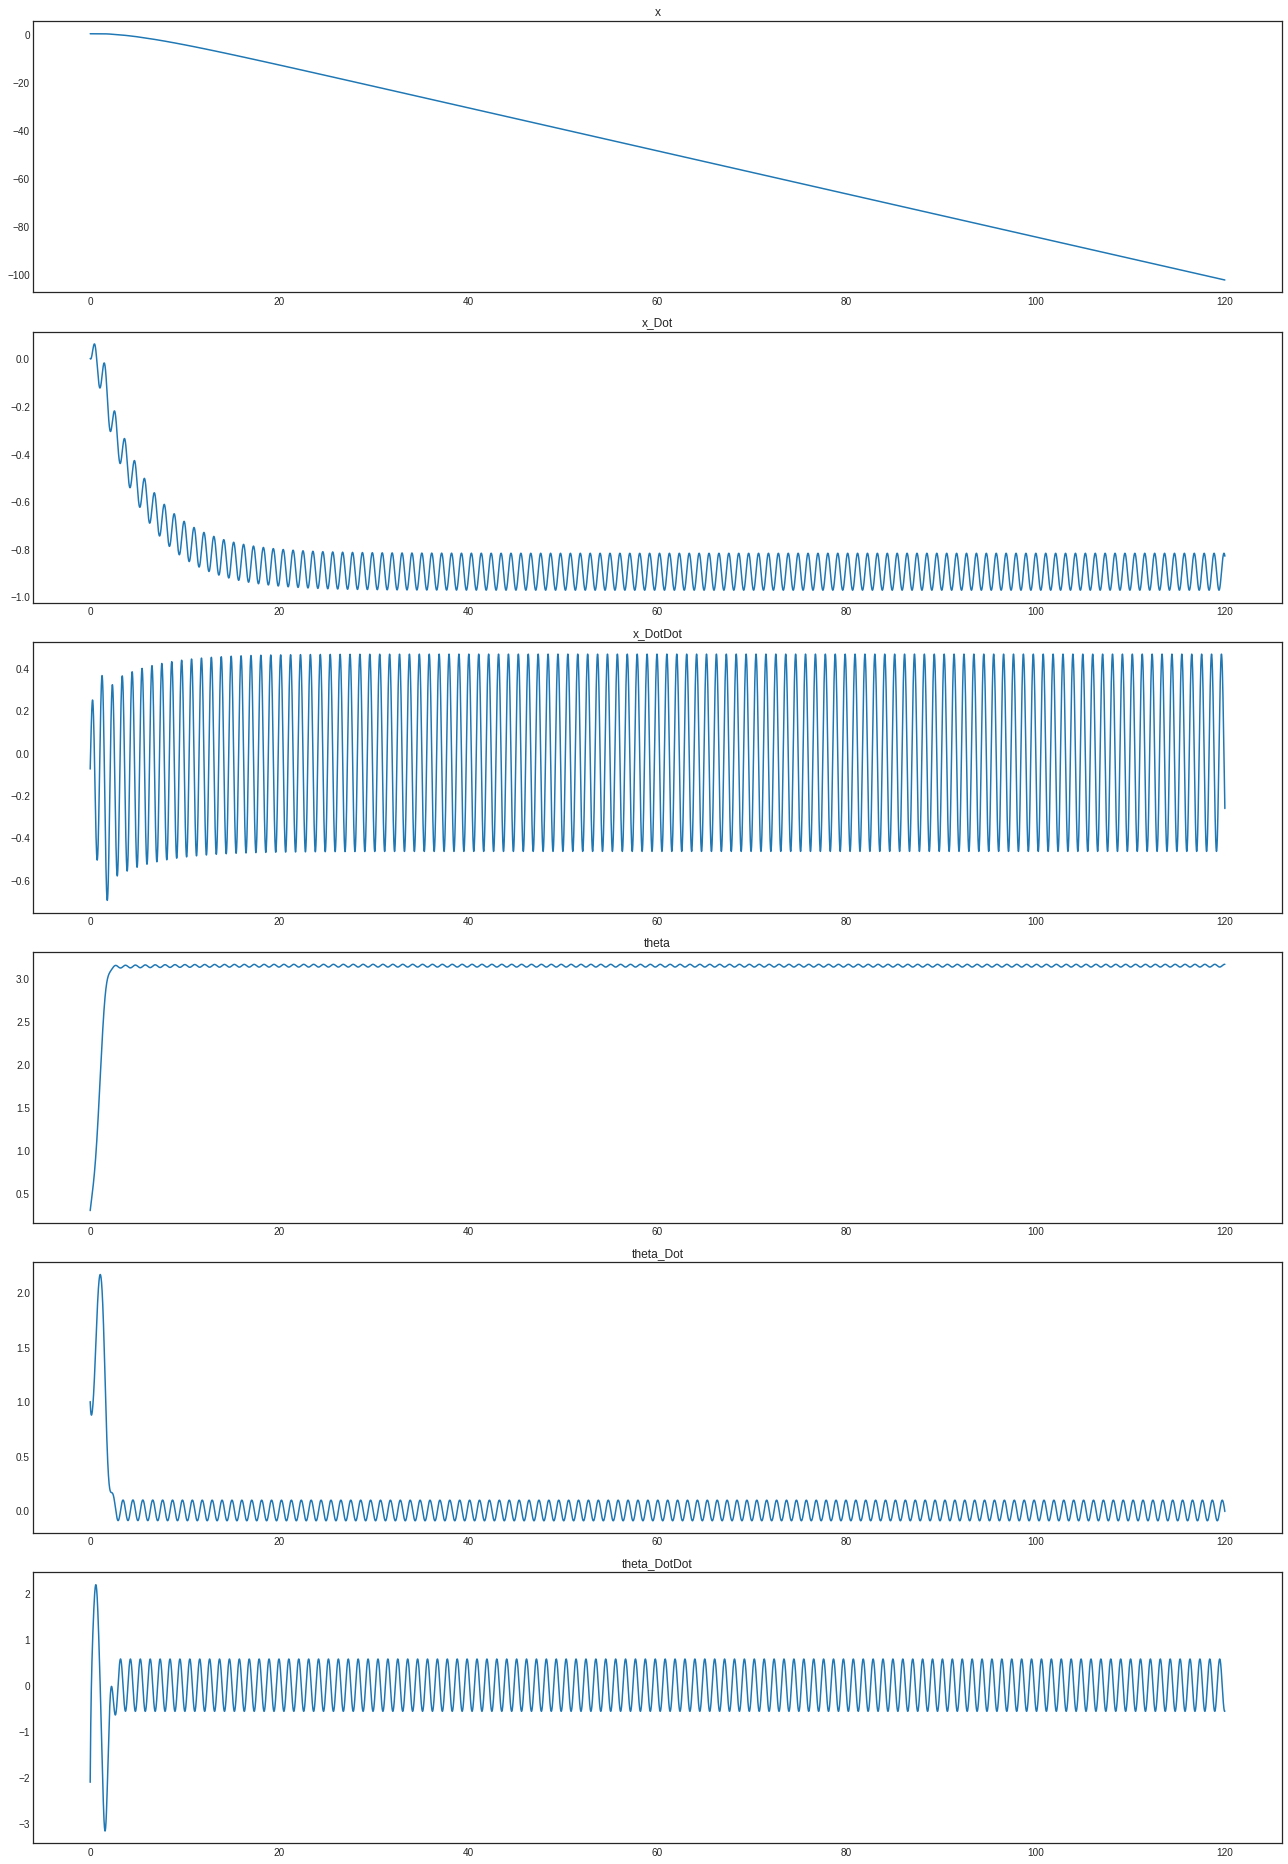

In [10]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

# Training 

In [11]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

X_prior = np.stack(((theta_sim-theta_sim_mean)/theta_sim_stdev,(theta_d_sim-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [12]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train_theta = torch.from_numpy(Y_train_theta).float()
Y_train_x = torch.from_numpy(Y_train_x).float()
X_prior = torch.from_numpy(X_prior).float()

# Putting tensors on GPU
X_train = X_train.cuda()
Y_train_theta = Y_train_theta.cuda()
Y_train_x = Y_train_x.cuda()
X_prior = X_prior.cuda()

# GPyTorch

In [13]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=4))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model (setting a lower bound on the noise so it does not go to zero)
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=gpytorch.priors.SmoothedBoxPrior(0.1, 1.5, sigma=0.001))

model_th = ExactGPModel(X_train, Y_train_theta, likelihood)
model_x = ExactGPModel(X_train, Y_train_x, likelihood)
# putting on GPU
model_x = model_x.cuda()
model_th = model_th.cuda()
likelihood = likelihood.cuda()

In [14]:
# Find optimal model hyperparameters
training_iter = 300

#with gpytorch.settings.max_cg_iterations(2000):
model_th.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_th.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_th)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_th(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train_theta)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_th.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/300 - Loss: 0.774  noise: 0.693
Iter 2/300 - Loss: 0.770  noise: 0.688
Iter 3/300 - Loss: 0.766  noise: 0.683
Iter 4/300 - Loss: 0.763  noise: 0.678
Iter 5/300 - Loss: 0.758  noise: 0.673
Iter 6/300 - Loss: 0.755  noise: 0.669
Iter 7/300 - Loss: 0.750  noise: 0.664
Iter 8/300 - Loss: 0.747  noise: 0.659
Iter 9/300 - Loss: 0.744  noise: 0.654
Iter 10/300 - Loss: 0.738  noise: 0.649
Iter 11/300 - Loss: 0.735  noise: 0.644
Iter 12/300 - Loss: 0.732  noise: 0.640
Iter 13/300 - Loss: 0.728  noise: 0.635
Iter 14/300 - Loss: 0.724  noise: 0.630
Iter 15/300 - Loss: 0.720  noise: 0.626
Iter 16/300 - Loss: 0.717  noise: 0.621
Iter 17/300 - Loss: 0.712  noise: 0.616
Iter 18/300 - Loss: 0.709  noise: 0.612
Iter 19/300 - Loss: 0.704  noise: 0.607
Iter 20/300 - Loss: 0.700  noise: 0.603
Iter 21/300 - Loss: 0.698  noise: 0.598
Iter 22/300 - Loss: 0.692  noise: 0.594
Iter 23/300 - Loss: 0.688  noise: 0.589
Iter 24/300 - Loss: 0.685  noise: 0.585
Iter 25/300 - Loss: 0.680  noise: 0.580
Iter 26/3

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.6539881229400635 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 276/300 - Loss: nan  noise: 0.059
Iter 277/300 - Loss: nan  noise: 0.059


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5174.6650390625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 278/300 - Loss: nan  noise: 0.059


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5838.9208984375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 279/300 - Loss: nan  noise: 0.058
Iter 280/300 - Loss: nan  noise: 0.059
Iter 281/300 - Loss: nan  noise: 0.059
Iter 282/300 - Loss: nan  noise: 0.060


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2811058.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 283/300 - Loss: nan  noise: 0.061


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10846459.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 284/300 - Loss: nan  noise: 0.061


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 41945120.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 285/300 - Loss: nan  noise: 0.062


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 435969632.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 286/300 - Loss: nan  noise: 0.063


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 10379096.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 287/300 - Loss: nan  noise: 0.064


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2193975552.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 288/300 - Loss: nan  noise: 0.064


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 19647532.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 289/300 - Loss: nan  noise: 0.065


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 21128832.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 290/300 - Loss: nan  noise: 0.066


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 45572104.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 291/300 - Loss: nan  noise: 0.068


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 70683352.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 292/300 - Loss: nan  noise: 0.069


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3101365.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 293/300 - Loss: nan  noise: 0.069


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2349312.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 294/300 - Loss: -0.018  noise: 0.070


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 56415792.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 295/300 - Loss: nan  noise: 0.071


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7190109.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 296/300 - Loss: nan  noise: 0.072


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 288370.03125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 297/300 - Loss: nan  noise: 0.072


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 75845992.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 298/300 - Loss: nan  noise: 0.073


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2964160.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 299/300 - Loss: nan  noise: 0.073
Iter 300/300 - Loss: nan  noise: 0.074


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 89518008.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


In [8]:
# Find optimal model hyperparameters
training_iter = 300

model_x.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_x.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_x)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_x(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train_x)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_x.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/300 - Loss: -0.458  noise: 0.058
Iter 2/300 - Loss: -0.466  noise: 0.057
Iter 3/300 - Loss: -0.473  noise: 0.057
Iter 4/300 - Loss: -0.479  noise: 0.056
Iter 5/300 - Loss: -0.484  noise: 0.056
Iter 6/300 - Loss: -0.487  noise: 0.055
Iter 7/300 - Loss: -0.494  noise: 0.055
Iter 8/300 - Loss: -0.499  noise: 0.054
Iter 9/300 - Loss: -0.501  noise: 0.054
Iter 10/300 - Loss: -0.511  noise: 0.053
Iter 11/300 - Loss: -0.512  noise: 0.053
Iter 12/300 - Loss: -0.519  noise: 0.052
Iter 13/300 - Loss: -0.522  noise: 0.052
Iter 14/300 - Loss: -0.529  noise: 0.051
Iter 15/300 - Loss: -0.536  noise: 0.051
Iter 16/300 - Loss: -0.539  noise: 0.050
Iter 17/300 - Loss: -0.545  noise: 0.050
Iter 18/300 - Loss: -0.548  noise: 0.049
Iter 19/300 - Loss: -0.550  noise: 0.049
Iter 20/300 - Loss: -0.561  noise: 0.048
Iter 21/300 - Loss: -0.561  noise: 0.048
Iter 22/300 - Loss: -0.570  noise: 0.047
Iter 23/300 - Loss: -0.577  noise: 0.047
Iter 24/300 - Loss: -0.582  noise: 0.046
Iter 25/300 - Loss: -0.58

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.568258285522461 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 141/300 - Loss: nan  noise: 0.014
Iter 142/300 - Loss: nan  noise: 0.014
Iter 143/300 - Loss: nan  noise: 0.014
Iter 144/300 - Loss: nan  noise: 0.014
Iter 145/300 - Loss: nan  noise: 0.014
Iter 146/300 - Loss: nan  noise: 0.014
Iter 147/300 - Loss: nan  noise: 0.013
Iter 148/300 - Loss: nan  noise: 0.013
Iter 149/300 - Loss: -1.219  noise: 0.013
Iter 150/300 - Loss: nan  noise: 0.013
Iter 151/300 - Loss: nan  noise: 0.013
Iter 152/300 - Loss: nan  noise: 0.013
Iter 153/300 - Loss: nan  noise: 0.013


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.34208607673645 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 154/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4577.1650390625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 155/300 - Loss: nan  noise: 0.012
Iter 156/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7595.0888671875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 157/300 - Loss: -1.278  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 974.3502807617188 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 158/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2477856.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 159/300 - Loss: -1.278  noise: 0.011


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 74218264.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 160/300 - Loss: nan  noise: 0.011


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 69586.5390625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 161/300 - Loss: nan  noise: 0.011


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 94313.421875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 162/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16518.130859375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 163/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 401.82733154296875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 164/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2015.531494140625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 165/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1855.9420166015625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 166/300 - Loss: -1.261  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6599.287109375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 167/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 8579.400390625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 168/300 - Loss: -1.251  noise: 0.012
Iter 169/300 - Loss: nan  noise: 0.012
Iter 170/300 - Loss: nan  noise: 0.012
Iter 171/300 - Loss: nan  noise: 0.012
Iter 172/300 - Loss: nan  noise: 0.012
Iter 173/300 - Loss: nan  noise: 0.012


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.062215805053711 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 174/300 - Loss: nan  noise: 0.012
Iter 175/300 - Loss: nan  noise: 0.012
Iter 176/300 - Loss: nan  noise: 0.013
Iter 177/300 - Loss: nan  noise: 0.013
Iter 178/300 - Loss: nan  noise: 0.013
Iter 179/300 - Loss: nan  noise: 0.013
Iter 180/300 - Loss: nan  noise: 0.013
Iter 181/300 - Loss: nan  noise: 0.013
Iter 182/300 - Loss: -1.239  noise: 0.013
Iter 183/300 - Loss: -1.248  noise: 0.013
Iter 184/300 - Loss: nan  noise: 0.013
Iter 185/300 - Loss: nan  noise: 0.013
Iter 186/300 - Loss: nan  noise: 0.013
Iter 187/300 - Loss: -1.234  noise: 0.013
Iter 188/300 - Loss: nan  noise: 0.013
Iter 189/300 - Loss: nan  noise: 0.013
Iter 190/300 - Loss: nan  noise: 0.013
Iter 191/300 - Loss: nan  noise: 0.013
Iter 192/300 - Loss: nan  noise: 0.013
Iter 193/300 - Loss: nan  noise: 0.013
Iter 194/300 - Loss: nan  noise: 0.013
Iter 195/300 - Loss: nan  noise: 0.013
Iter 196/300 - Loss: nan  noise: 0.013
Iter 197/300 - Loss: nan  noise: 0.013
Iter 198/300 - Loss: -1.229  noise: 0.013
Iter 199/300 

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5778610706329346 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 267/300 - Loss: nan  noise: 0.013
Iter 268/300 - Loss: nan  noise: 0.013
Iter 269/300 - Loss: nan  noise: 0.013
Iter 270/300 - Loss: nan  noise: 0.013
Iter 271/300 - Loss: nan  noise: 0.013
Iter 272/300 - Loss: nan  noise: 0.013
Iter 273/300 - Loss: -1.235  noise: 0.013
Iter 274/300 - Loss: nan  noise: 0.013
Iter 275/300 - Loss: nan  noise: 0.013
Iter 276/300 - Loss: nan  noise: 0.013
Iter 277/300 - Loss: nan  noise: 0.013
Iter 278/300 - Loss: nan  noise: 0.013
Iter 279/300 - Loss: nan  noise: 0.013
Iter 280/300 - Loss: nan  noise: 0.013
Iter 281/300 - Loss: nan  noise: 0.013


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.05219566822052 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 282/300 - Loss: nan  noise: 0.013
Iter 283/300 - Loss: nan  noise: 0.013
Iter 284/300 - Loss: nan  noise: 0.013


/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.9443899393081665 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 285/300 - Loss: nan  noise: 0.013
Iter 286/300 - Loss: nan  noise: 0.013
Iter 287/300 - Loss: nan  noise: 0.013
Iter 288/300 - Loss: -1.233  noise: 0.013
Iter 289/300 - Loss: -1.237  noise: 0.013
Iter 290/300 - Loss: nan  noise: 0.013
Iter 291/300 - Loss: nan  noise: 0.013
Iter 292/300 - Loss: nan  noise: 0.013
Iter 293/300 - Loss: -1.242  noise: 0.013
Iter 294/300 - Loss: -1.227  noise: 0.013
Iter 295/300 - Loss: nan  noise: 0.013
Iter 296/300 - Loss: nan  noise: 0.013
Iter 297/300 - Loss: nan  noise: 0.013
Iter 298/300 - Loss: nan  noise: 0.013
Iter 299/300 - Loss: nan  noise: 0.013
Iter 300/300 - Loss: -1.233  noise: 0.013


In [9]:
# save models 
torch.save(model_th.state_dict(), '../../learnedModels/noisyCase/th_RatQuad_gpytorch')
torch.save(model_x.state_dict(), '../../learnedModels/noisyCase/x_RatQuad_gpytorch')

In [10]:
#gpytorch.settings.max_cg_iterations(2000)

# Get into evaluation (predictive posterior) mode
model_th.load_state_dict(torch.load('../../learnedModels/noisyCase/th_RatQuad_gpytorch'))

model_th.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_th = likelihood(model_th(X_prior))

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2761.882080078125 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


In [11]:
# Get into evaluation (predictive posterior) mode
model_x.load_state_dict(torch.load('../../learnedModels/noisyCase/x_RatQuad_gpytorch'))

model_x.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_x = likelihood(model_x(X_prior))

In [12]:
# Putting back on CPU
X_train = X_train.cpu()
Y_train_theta = Y_train_theta.cpu()
Y_train_x = Y_train_x.cpu()
X_prior = X_prior.cpu()

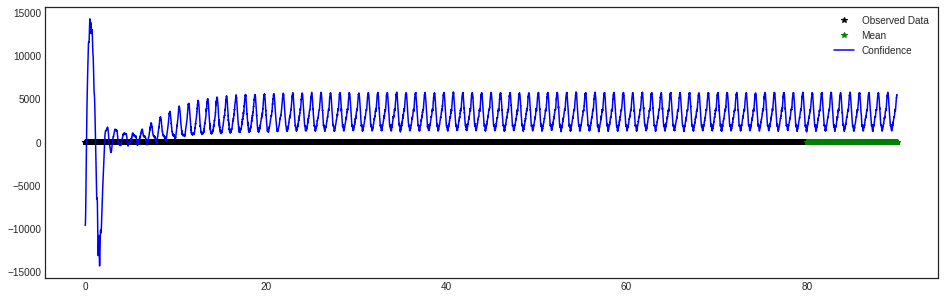

In [13]:
star_Traj = 0
mids_Traj = 8000
ends_Traj = 9000

with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1)

    fig.set_figheight(5)
    fig.set_figwidth(16)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_th.confidence_region()
    lower = lower.cpu()
    upper = upper.cpu()
    mean = observed_pred_th.mean
    mean = mean.cpu()
    ax.plot(timeSteps[star_Traj:mids_Traj], Y_train_theta[star_Traj:], 'k*')
    ax.plot(timeSteps[mids_Traj:ends_Traj], Y_test_theta[:ends_Traj-mids_Traj], 'g*')
    ax.plot(timeSteps[star_Traj:ends_Traj], mean.numpy()[star_Traj:ends_Traj], 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(timeSteps[star_Traj:ends_Traj], lower.numpy()[star_Traj:ends_Traj], upper.numpy()[star_Traj:ends_Traj], alpha=0.3)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

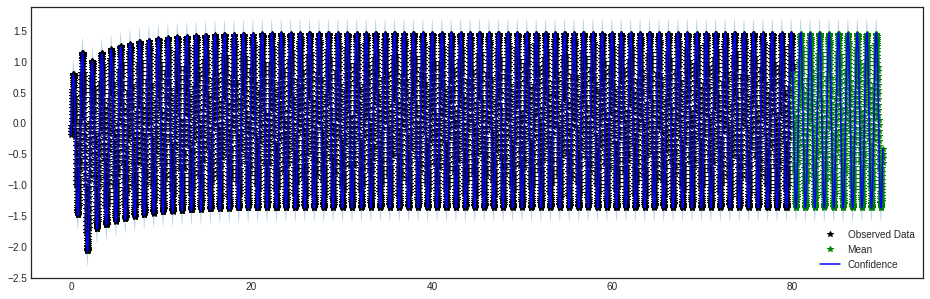

In [14]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1)

    fig.set_figheight(5)
    fig.set_figwidth(16)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_x.confidence_region()
    lower = lower.cpu()
    upper = upper.cpu()
    mean = observed_pred_x.mean
    mean = mean.cpu()
    ax.plot(timeSteps[star_Traj:mids_Traj], Y_train_x[star_Traj:], 'k*')
    ax.plot(timeSteps[mids_Traj:ends_Traj], Y_test_x[:ends_Traj-mids_Traj], 'g*')
    ax.plot(timeSteps[star_Traj:ends_Traj], mean.numpy()[star_Traj:ends_Traj], 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(timeSteps[star_Traj:ends_Traj], lower.numpy()[star_Traj:ends_Traj], upper.numpy()[star_Traj:ends_Traj], alpha=0.3)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# RMSE

In [15]:
model_th.load_state_dict(torch.load('../../learnedModels/noisyCase/th_RatQuad_gpytorch'))
model_x.load_state_dict(torch.load('../../learnedModels/noisyCase/x_RatQuad_gpytorch'))

<All keys matched successfully>

In [16]:
trunc_st = 0
trunc_en = 9000

X_prior = np.stack(((theta_sim[trunc_st:trunc_en]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[trunc_st:trunc_en]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[trunc_st:trunc_en]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[trunc_st:trunc_en]-forceIn_mean)/forceIn_stdev), axis=1)
#X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

# Putting back on CPU
X_prior = torch.from_numpy(X_prior).float()
X_prior = X_prior.cuda()

In [17]:
mu_th_dd = np.zeros(X_prior.shape[0])
lower_th, upper_th = np.zeros(X_prior.shape[0]), np.zeros(X_prior.shape[0])
gp_th_d = np.zeros(X_prior.shape[0])
gp_th = np.zeros(X_prior.shape[0])

mu_x_dd = np.zeros(X_prior.shape[0])
lower_x, upper_x = np.zeros(X_prior.shape[0]), np.zeros(X_prior.shape[0])
gp_x_d = np.zeros(X_prior.shape[0])
gp_x = np.zeros(X_prior.shape[0])

mu_th_dd[0] =  theta_dd_sim[trunc_st]
gp_th_d[0] = theta_d_sim[trunc_st]
gp_th[0] = theta_sim[trunc_st]
mu_x_dd[0] = x_dd_sim[trunc_st]
gp_x_d[0] = x_d_sim[trunc_st]
gp_x[0] = x_sim[trunc_st]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        model_th.eval()
        model_x.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred_th = likelihood(model_th(X_prior[k,:].reshape(1,-1)))
            observed_pred_x = likelihood(model_x(X_prior[k,:].reshape(1,-1)))
            mu_th_dd[k+1] = observed_pred_th.mean
            mu_x_dd[k+1] = observed_pred_x.mean
            lower_th[k+1], upper_th[k+1] = observed_pred_th.confidence_region()
            lower_x[k+1], upper_x[k+1] = observed_pred_x.confidence_region()
        unstand_acc = mu_th_dd[k+1]*theta_dd_sim_stdev + theta_dd_sim_mean
        gp_th_d[k+1] = gp_th_d[k]+(unstand_acc)*(dt)
        #X_prior[k+1,1] = (gp_th_d[k+1]-theta_d_sim_mean) / theta_d_sim_stdev
        gp_th[k+1] = gp_th[k] + (gp_th_d[k+1] + gp_th_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)
        #X_prior[k+1,0] = (gp_th[k+1]-theta_sim_mean) / theta_sim_stdev
        unstand_x = mu_x_dd[k+1]*x_dd_sim_stdev + x_dd_sim_mean
        gp_x_d[k+1] = gp_x_d[k]+(unstand_x)*(dt)
        #X_prior[k+1,2] = (gp_x_d[k+1]-x_d_sim_mean) / x_d_sim_stdev
        gp_x[k+1] = gp_x[k] + (gp_x_d[k+1] + gp_x_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)

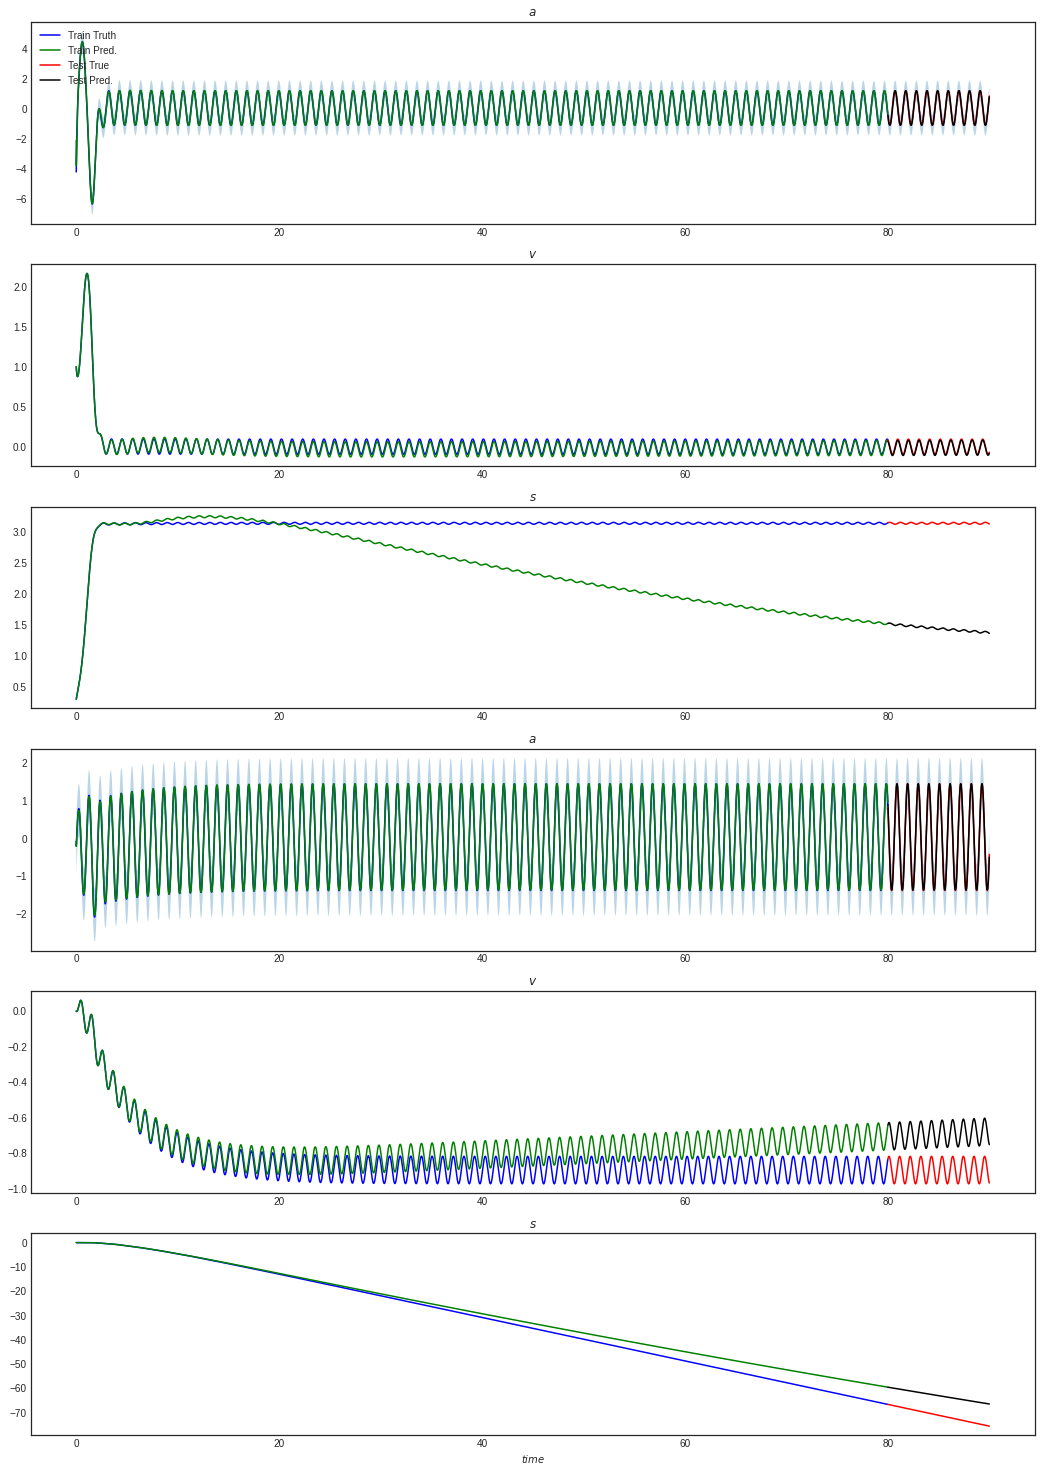

In [18]:
# Plotting 
train_test_split = 8000 # define it above later on 

st_Trajec = trunc_st
mid_Trajec = train_test_split
en_Trajec = trunc_en

# For predictions
mid_pred = train_test_split - trunc_st 

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6) 

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.fill_between(timeSteps[st_Trajec:en_Trajec], lower_th, upper_th, alpha=0.3)
b1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_theta[st_Trajec:mid_Trajec], "b")
g1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], mu_th_dd[:mid_pred], "g")
r1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_theta[:en_Trajec-mid_Trajec], "r")
k1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], mu_th_dd[mid_pred:], "k")
ax1.set_title('$a$')

ax2.plot(timeSteps[st_Trajec:mid_Trajec], theta_d_sim[st_Trajec:mid_Trajec], "b")
ax2.plot(timeSteps[st_Trajec:mid_Trajec], gp_th_d[:mid_pred], "g")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], theta_d_sim[mid_Trajec:en_Trajec], "r")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], gp_th_d[mid_pred:], "k")
ax2.set_title('$v$')

ax3.plot(timeSteps[st_Trajec:mid_Trajec], theta_sim[st_Trajec:mid_Trajec], "b")
ax3.plot(timeSteps[st_Trajec:mid_Trajec], gp_th[:mid_pred], "g")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], theta_sim[mid_Trajec:en_Trajec], "r")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], gp_th[mid_pred:], "k")
ax3.set_title('$s$')

ax4.fill_between(timeSteps[st_Trajec:en_Trajec], lower_x, upper_x, alpha=0.3)
ax4.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_x[st_Trajec:], "b")
ax4.plot(timeSteps[st_Trajec:mid_Trajec], mu_x_dd[:mid_pred], "g")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_x[:en_Trajec-mid_Trajec], "r")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], mu_x_dd[mid_pred:], "k")
ax4.set_title('$a$')

ax5.plot(timeSteps[st_Trajec:mid_Trajec], x_d_sim[st_Trajec:mid_Trajec], "b")
ax5.plot(timeSteps[st_Trajec:mid_Trajec], gp_x_d[:mid_pred], "g")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], x_d_sim[mid_Trajec:en_Trajec], "r")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], gp_x_d[mid_pred:], "k")
ax5.set_title('$v$')

ax6.plot(timeSteps[st_Trajec:mid_Trajec], x_sim[st_Trajec:mid_Trajec], "b")
ax6.plot(timeSteps[st_Trajec:mid_Trajec], gp_x[:mid_pred], "g")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], x_sim[mid_Trajec:en_Trajec], "r")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], gp_x[mid_pred:], "k")
ax6.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('GP_Exp_Stand_JIANG(A).png')
plt.show()